# Approximating electromagnetic shielding using deep learning

Here we are digging the deep learning part of the automated learning. We wish to see by ourselves to which extends this is appliable to our case and if it gives better results than standard machine learning.

When designing algorithms, we always have to wonder what are the requirements in terms of time / performance trade-off. In our case, the performance is the most important. Computation time should of course stay reasonable but considering the time taken to construct the matrix on which we train, as long as our algorithms don't take several minutes to run they will not take the major part of the overall time.

Note that deep-learning algorithms rely a lot on data. The more you have, the better your predictions will be. Hence we highly recommand that whenever more data are available to rerun the algorithms.

In [23]:
# Clean up the memory
%reset

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
%load_ext autoreload
%autoreload 2

import gc

import crowd
import experts
import supercrowd as sc
import collaborative_crowd as cc

import numpy as np
import math
from PIL import Image
import timeit

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.constraints import MaxNorm

import matplotlib.pyplot as plt

In [2]:
DATA_FOLDER = "data/"
SESSION_FOLDER = "session/"

TRAIN_SET_PERC = 0.75

In [3]:
def rmse(pred, real, loop = True):
    '''
    Computes RMSE between predictions and real values
    :param : float[]
    :param : float[]
    :return : float
    '''
    if len(pred) != len(real):
        print("RMSE Error : Predictions and real values arrays do not have the same length, aborting.")
        return None
    
    if loop:
        mse = 0
        for i in range(len(pred)):
            mse += (pred[i] - real[i])**2
        return math.sqrt(mse/len(pred))
    else:
        # The creation of the array may produce memory error
        err = pred - real
        mse = err.T @ err
        return math.sqrt(2 * mse / len(pred))
    
    
def basic_error(pred, real):
    '''
    Compute basic error. Used to notify bias.
    :param : float[]
    :param : float[]
    :return : float
    '''
    err = 0
    for i in range(len(pred)):
        err += (pred[i][0][0] - real[i])
    return err


def garbage_collection():
    '''
    Calls garbage collection to clean unused memory
    '''
    gc.collect()

In [4]:
def plot_history(history):
    '''
    Plots the history of the training error
    '''
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error')
    plt.plot(history.epoch, np.array(history.history['mean_absolute_error']),
           label='Train Loss')
    plt.plot(history.epoch, np.array(history.history['val_mean_absolute_error']),
           label = 'Val loss')
    plt.legend()
    plt.ylim([0, 5])

## Preparing the data

First, we need to prepare the data in a train / test split. The test part is required to have good approximation of the error on unseen data. The lab asked for a $75$ / $25$ train / test split, we select the samples at random to avoid training only on a subset of the data (note that this is overkill since the lab revealed us that the samples were already randomized).

And the last, but not the least, detail : we add a random seed in our random selection to ensure reproducibility.

In [5]:
X_red = np.load(DATA_FOLDER + "feature_mat_radial_compression_normalized_red.npy")
y = np.load(DATA_FOLDER + "CSD500-r_train-H_total.npy")

train_set_size = int(len(X_red) * TRAIN_SET_PERC)
# Select random rows of the matrix for train / test set
# Random seed for reproducibility 
np.random.seed(100)
train_idx = np.random.choice(len(X_red), size=train_set_size, replace = False)
test_idx = [i for i in range(len(X_red)) if i not in train_idx]
X_train_red = X_red[train_idx, :]
X_test_red = X_red[test_idx, :]
y_train = y[train_idx]
y_test = y[test_idx]
print("X_red: " + str(X_red.shape))
print("y: " + str(y.shape))

X_red: (30049, 3004)
y: (30049,)


# Single neural network model approach 

First, we want to see how well a single neural network can perform on the data we have at our disposal. Highly influenced by tensorflow's tutorials and Standford University CS231n Convolutional Neural Networks for Visual Recognition lecture (http://cs231n.github.io/), we build our first neural network.

We also execute cross-validations on the relevant parameters to get the best RMSE out of the network.

In [19]:
def train_and_pred(nb_layers, nb_neurons, regularizer_fac, optimizer_fac):
    # Prepare model 
    model = tf.keras.Sequential()
    for i in range(nb_layers):
        model.add(layers.Dense(nb_neurons, activation='relu', \
                               kernel_regularizer=tf.keras.regularizers.l2(regularizer_fac)))
    # Last layer represent the electromagnetic shielding, our prediction
    model.add(layers.Dense(1, activation='relu'))

    model.compile(optimizer=tf.train.AdamOptimizer(optimizer_fac),
                  loss='mse',
                  # Note that the accuracy metric is useless but it doesn't compile when trying to use RMSE.
                  metrics=['mae'])
    EPOCHS = 200
    BATCH_SIZE = 32
    VALIDATION_SPLIT = 0.1
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

    history = model.fit(X_train_red, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split = VALIDATION_SPLIT, \
              callbacks=[early_stop])
    plot_history(history)
    
    result = model.predict(X_test_red, batch_size=32)
    error = rmse(result, y_test)
    print("Error : {}".format(error))
    return error

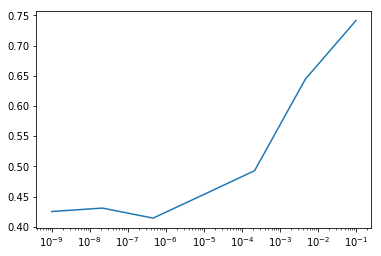

In [22]:
errors = [0.7416394267991249, 0.6443409956831526, 0.4930030937745785, \
         0.453638706377575, 0.41453323956187177, 0.4311010863788413, 0.4254569121978898]

x = np.logspace(-1, -9, 7)

plt.semilogx(x, errors)

In [ ]:
# This will train the neural network and print its error on the test set.
# Since tensorflow is very talkative when training a network, we remove the output for the comfort of the reader.
error = train_and_pred(8, 156, 1e-6, 0.001)

## Results of cross validation over regularization factor

For the sake of sanity, we only display the results we obtained to avoid recomputing them. The previous graph shows evolution of the RMSE for a single neural network versus the L2 regularization factor.

The number of layers and neurons by layers was chosen such that the model is powerful enough to capture most of the complexity of the model, overfitting being taken care with the L2-regularization. 

As for the optimizer factor, it will not influence the accuracy of our predictions but rather the convergence times. Hence we chose a factor that allowed us to converge while keeping a decent amount of epochs.

## Final optimized structure :

- Train / test split : $75$ / $25$.
- Number of hidden layers : $8$.
- Number of neuron / layers : $156$.
- Activations : Rectified Linear Unit (relu).
- Regularizer : L2 regularizer with factor $10^{-6}$.
- Optimizer : Adam Optimizer with factor $10^{-3}$.
- Single network error : 0.43.

# Crowd of Neural Networks Approach

Now we try a new approach based on the *Wisdom Of Crowds* principle which states that the average of the predictions of a crowd is almost always better than the prediction of a single expert.

Hence we will create a Crowd composed of a multitude of networks, train them all on the same training set and then ask them all to predict the test data. We will then average their predictions to give the final answer of the crowd, counting on the randomness of the neural network algorithm to give different answers for each individual, needed assumption for the principle to hold.

Note that most of the code for this part is located in the Crowd class, itself defined in the file crowd.py.

The structure of each networks we use is the optimized one we found in the previous part. Note also that the crowds are pretty long to train, to have good approximations, the more networks they have, the better. However this training should be done only once and each network is saved in the directory of its crowd in the folder '/session'.

In [24]:
crowd_opt2 = crowd.Crowd(X_train_red, y_train, "Crowd_opt_2", nb_layers = 8, \
                      nb_neurons=156, regularization_factor=1e-6, validation_split = 0)
# Recover the crowd from file.
# The file should be located in the 'session' folder
crowd_opt2.restore()

Recovered 16 entities from session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/16


In [6]:
# This will add new networks to the crowd. Note that this is a long operation (up to 2 hours for 8 entities).
crowd_opt2.train_new_entities(8)

In [25]:
# Predict on the test set and compute RMSE
start = timeit.default_timer()
pred = crowd_opt2.predict(X_test_red)
stop = timeit.default_timer()
error_rmse = rmse(pred, y_test)
print('Prediction time for {} samples : {} seconds\nRMSE : {} '.format(len(X_test_red), stop - start, error_rmse))

Prediction time for 7513 samples : 185.83958538400475 seconds
RMSE : 0.35298389679256353 


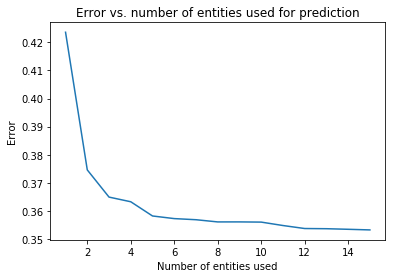

In [26]:
# Plot the crowd error vs the number of networks used for prediction
crowd_opt2.plot_crowd_error(X_test_red, y_test, rmse)

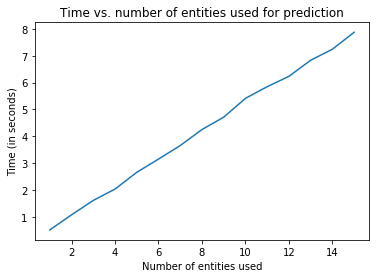

In [27]:
# Plot the prediction time vs the number of networks used
crowd_opt2.plot_crowd_pred_time(X_test_red)

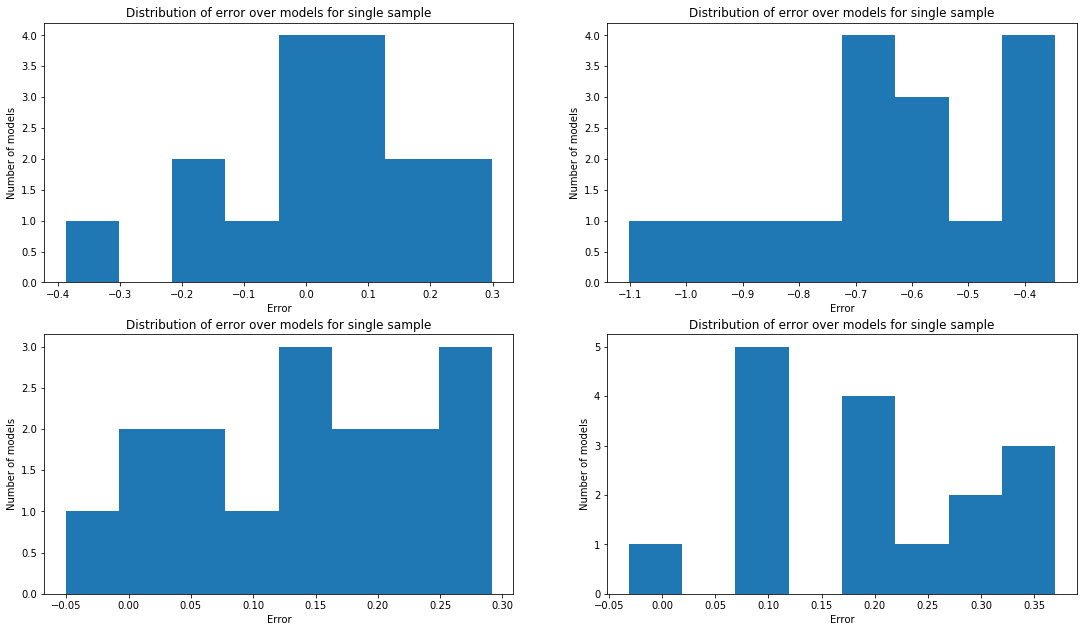

In [28]:
# Plot the distribution of the error of the different networks over a single sample
nb_bins = 8
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.subplot(221)
crowd_opt2.plot_error_dist_on_sample(X_test_red[0], y_test[0], basic_error, show = False, bins = nb_bins)
plt.subplot(222)
crowd_opt2.plot_error_dist_on_sample(X_test_red[1], y_test[1], basic_error, show = False, bins = nb_bins)
plt.subplot(223)
crowd_opt2.plot_error_dist_on_sample(X_test_red[2], y_test[2], basic_error, show = False, bins = nb_bins)
plt.subplot(224)
crowd_opt2.plot_error_dist_on_sample(X_test_red[3], y_test[3], basic_error, show = False, bins = nb_bins)
plt.show()

### A wild idea : use a neural network stacked above the crowd for the prediction

This idea is not detailed in the report because it doesn't bring better results than the ones we already have. And because we are limited to 4 pages for the report we had to make choices.

This type of predictions adds a neural network on top of the crowd to make the prediction. This network will train on the whole training matrix but also on all the predictions of the other networks of the crowd. Doing so should learn him how the other networks did and it may ameliorate its predictions with this knowledge.

In [ ]:
# Make a prediction using a stacker at the end of the crowd
# Again output is removed because of tensorflow verbosity.
print("RMSE using stacker : {}".format(rmse(crowd_opt2.predict_stacked(X_test_red), y_test)))

## Conclusion

Looking at the error versus the number of networks used for prediction, the results is undeniable : the crowd definetely reduce our error in an impressive way.

We can clearly see that the error follows an exponential decay when compared to the number of networks used for a linear increase of the computation time. From the plot of the distribution of the error over a single sample, we can see that it is more or less gaussianly distributed. However we observe that this gaussian distribution is not centered around 0 which means that adding more and more networks will not necessarly brought us to a RMSE of $0$. 

Consequently, we have to find better ways of ameliorate the error.

As a side note, please consider the error obtained with the stacked_prediction. Although it is not as good as the average of the predictions of the crowd (around $0.35$) it is better than the single network error (around $0.43$). Keep this in mind since it will be the starting point of our collaborative crowds.

## Final structure :

- Each network composing the crowd is an instance of the optimized version found in the first part.
- 16 entities (more will bring better results but also increase the prediction time).
- Crowd error : $0.353$.

# Mixture of experts

Finally we want to test a last method : instead of assigning the same weight to the prediction of each individual of the Crowd, we will try to assign different weights based on ressemblance between the sample to predict and the samples on which the individual performed best. 

If the data is categorizable, this method may give very good results. The core code is located in the file experts.py.

In [12]:
experts01 = experts.Experts(X_train_red, y_train, "Experts_opt1", nb_layers = 8, \
                      nb_neurons=156, regularization_factor=1e-6, validation_split = 0)
experts01.restore()

No directory with name session/Experts_opt1_8_156_relu_1e-06_0.001_mse


In [13]:
experts01.train_new_entities(8)

Epoch 1/200
22528/22536 [============================>.] - ETA: 0s - loss: 34.2623 - mean_absolute_error: 3.3461
Epoch 00001: saving model to session/Experts_opt1_8_156_relu_1e-06_0.001_mse/0
22536/22536 [==============================] - 7s 290us/step - loss: 34.2507 - mean_absolute_error: 3.3453
Epoch 2/200
22432/22536 [============================>.] - ETA: 0s - loss: 4.2818 - mean_absolute_error: 1.4643
Epoch 00002: saving model to session/Experts_opt1_8_156_relu_1e-06_0.001_mse/0
22536/22536 [==============================] - 5s 219us/step - loss: 4.2735 - mean_absolute_error: 1.4623
Epoch 3/200
22464/22536 [============================>.] - ETA: 0s - loss: 1.0801 - mean_absolute_error: 0.7410
Epoch 00003: saving model to session/Experts_opt1_8_156_relu_1e-06_0.001_mse/0
22536/22536 [==============================] - 5s 205us/step - loss: 1.0807 - mean_absolute_error: 0.7412
Epoch 4/200
22432/22536 [============================>.] - ETA: 0s - loss: 0.5109 - mean_absolute_error: 0.

Epoch 29/200
22272/22536 [============================>.] - ETA: 0s - loss: 0.7842 - mean_absolute_error: 0.2823
Epoch 00029: saving model to session/Experts_opt1_8_156_relu_1e-06_0.001_mse/0
22536/22536 [==============================] - 4s 185us/step - loss: 0.8219 - mean_absolute_error: 0.2976
Epoch 30/200
22336/22536 [============================>.] - ETA: 0s - loss: 0.2277 - mean_absolute_error: 0.3198
Epoch 00030: saving model to session/Experts_opt1_8_156_relu_1e-06_0.001_mse/0
22536/22536 [==============================] - 4s 185us/step - loss: 0.2265 - mean_absolute_error: 0.3191
Epoch 31/200
22336/22536 [============================>.] - ETA: 0s - loss: 0.0738 - mean_absolute_error: 0.1757
Epoch 00031: saving model to session/Experts_opt1_8_156_relu_1e-06_0.001_mse/0
22536/22536 [==============================] - 4s 186us/step - loss: 0.0739 - mean_absolute_error: 0.1760
Epoch 32/200
22464/22536 [============================>.] - ETA: 0s - loss: 0.0517 - mean_absolute_error: 

Epoch 5/200
22272/22536 [============================>.] - ETA: 0s - loss: 0.4259 - mean_absolute_error: 0.4904
Epoch 00005: saving model to session/Experts_opt1_8_156_relu_1e-06_0.001_mse/1
22536/22536 [==============================] - 4s 192us/step - loss: 0.4256 - mean_absolute_error: 0.4905
Epoch 6/200
22304/22536 [============================>.] - ETA: 0s - loss: 0.3563 - mean_absolute_error: 0.4461
Epoch 00006: saving model to session/Experts_opt1_8_156_relu_1e-06_0.001_mse/1
22536/22536 [==============================] - 4s 189us/step - loss: 0.3568 - mean_absolute_error: 0.4464
Epoch 7/200
22464/22536 [============================>.] - ETA: 0s - loss: 0.4028 - mean_absolute_error: 0.4682
Epoch 00007: saving model to session/Experts_opt1_8_156_relu_1e-06_0.001_mse/1
22536/22536 [==============================] - 4s 190us/step - loss: 0.4032 - mean_absolute_error: 0.4685
Epoch 8/200
22336/22536 [============================>.] - ETA: 0s - loss: 0.3406 - mean_absolute_error: 0.42

Epoch 33/200
22336/22536 [============================>.] - ETA: 0s - loss: 0.0757 - mean_absolute_error: 0.1970
Epoch 00033: saving model to session/Experts_opt1_8_156_relu_1e-06_0.001_mse/1
22536/22536 [==============================] - 4s 188us/step - loss: 0.0756 - mean_absolute_error: 0.1967
Epoch 34/200
22528/22536 [============================>.] - ETA: 0s - loss: 0.0734 - mean_absolute_error: 0.1966
Epoch 00034: saving model to session/Experts_opt1_8_156_relu_1e-06_0.001_mse/1
22536/22536 [==============================] - 4s 189us/step - loss: 0.0734 - mean_absolute_error: 0.1967
Epoch 35/200
22272/22536 [============================>.] - ETA: 0s - loss: 0.0716 - mean_absolute_error: 0.1929
Epoch 00035: saving model to session/Experts_opt1_8_156_relu_1e-06_0.001_mse/1
22536/22536 [==============================] - 4s 189us/step - loss: 0.0716 - mean_absolute_error: 0.1929
Epoch 36/200
22304/22536 [============================>.] - ETA: 0s - loss: 0.0777 - mean_absolute_error: 

Epoch 61/200
22272/22536 [============================>.] - ETA: 0s - loss: 0.0403 - mean_absolute_error: 0.1330
Epoch 00061: saving model to session/Experts_opt1_8_156_relu_1e-06_0.001_mse/1
22536/22536 [==============================] - 4s 190us/step - loss: 0.0403 - mean_absolute_error: 0.1329
Epoch 62/200
22336/22536 [============================>.] - ETA: 0s - loss: 0.0385 - mean_absolute_error: 0.1297
Epoch 00062: saving model to session/Experts_opt1_8_156_relu_1e-06_0.001_mse/1
22536/22536 [==============================] - 4s 189us/step - loss: 0.0385 - mean_absolute_error: 0.1298
Epoch 63/200
22368/22536 [============================>.] - ETA: 0s - loss: 0.0431 - mean_absolute_error: 0.1406
Epoch 00063: saving model to session/Experts_opt1_8_156_relu_1e-06_0.001_mse/1
22536/22536 [==============================] - 4s 189us/step - loss: 0.0431 - mean_absolute_error: 0.1405
Epoch 64/200
22304/22536 [============================>.] - ETA: 0s - loss: 0.0449 - mean_absolute_error: 

Epoch 89/200
22272/22536 [============================>.] - ETA: 0s - loss: 0.0342 - mean_absolute_error: 0.1170
Epoch 00089: saving model to session/Experts_opt1_8_156_relu_1e-06_0.001_mse/1
22536/22536 [==============================] - 4s 189us/step - loss: 0.0342 - mean_absolute_error: 0.1170
Epoch 90/200
22432/22536 [============================>.] - ETA: 0s - loss: 0.0347 - mean_absolute_error: 0.1187
Epoch 00090: saving model to session/Experts_opt1_8_156_relu_1e-06_0.001_mse/1
22536/22536 [==============================] - 4s 190us/step - loss: 0.0347 - mean_absolute_error: 0.1187
Epoch 91/200
22272/22536 [============================>.] - ETA: 0s - loss: 0.0359 - mean_absolute_error: 0.1223
Epoch 00091: saving model to session/Experts_opt1_8_156_relu_1e-06_0.001_mse/1
22536/22536 [==============================] - 4s 190us/step - loss: 0.0359 - mean_absolute_error: 0.1223
Epoch 92/200
22368/22536 [============================>.] - ETA: 0s - loss: 0.0337 - mean_absolute_error: 

22536/22536 [==============================] - 4s 189us/step - loss: 0.0325 - mean_absolute_error: 0.1109
Epoch 117/200
22304/22536 [============================>.] - ETA: 0s - loss: 0.0279 - mean_absolute_error: 0.0999
Epoch 00117: saving model to session/Experts_opt1_8_156_relu_1e-06_0.001_mse/1
22536/22536 [==============================] - 4s 189us/step - loss: 0.0278 - mean_absolute_error: 0.0998
Epoch 118/200
22304/22536 [============================>.] - ETA: 0s - loss: 0.0279 - mean_absolute_error: 0.1001
Epoch 00118: saving model to session/Experts_opt1_8_156_relu_1e-06_0.001_mse/1
22536/22536 [==============================] - 4s 189us/step - loss: 0.0279 - mean_absolute_error: 0.1001
Epoch 119/200
22528/22536 [============================>.] - ETA: 0s - loss: 0.0280 - mean_absolute_error: 0.1023
Epoch 00119: saving model to session/Experts_opt1_8_156_relu_1e-06_0.001_mse/1
22536/22536 [==============================] - 4s 190us/step - loss: 0.0280 - mean_absolute_error: 0.10

22336/22536 [============================>.] - ETA: 0s - loss: 0.0278 - mean_absolute_error: 0.1010
Epoch 00144: saving model to session/Experts_opt1_8_156_relu_1e-06_0.001_mse/1
22536/22536 [==============================] - 4s 189us/step - loss: 0.0278 - mean_absolute_error: 0.1010
Epoch 145/200
22400/22536 [============================>.] - ETA: 0s - loss: 0.0258 - mean_absolute_error: 0.0946
Epoch 00145: saving model to session/Experts_opt1_8_156_relu_1e-06_0.001_mse/1
22536/22536 [==============================] - 4s 189us/step - loss: 0.0259 - mean_absolute_error: 0.0950
Epoch 146/200
22496/22536 [============================>.] - ETA: 0s - loss: 0.0276 - mean_absolute_error: 0.1018
Epoch 00146: saving model to session/Experts_opt1_8_156_relu_1e-06_0.001_mse/1
22536/22536 [==============================] - 4s 190us/step - loss: 0.0276 - mean_absolute_error: 0.1018
Epoch 147/200
22528/22536 [============================>.] - ETA: 0s - loss: 0.0261 - mean_absolute_error: 0.0972
Epo

Epoch 172/200
22528/22536 [============================>.] - ETA: 0s - loss: 0.0244 - mean_absolute_error: 0.0917
Epoch 00172: saving model to session/Experts_opt1_8_156_relu_1e-06_0.001_mse/1
22536/22536 [==============================] - 4s 190us/step - loss: 0.0244 - mean_absolute_error: 0.0917
Epoch 173/200
22368/22536 [============================>.] - ETA: 0s - loss: 0.0249 - mean_absolute_error: 0.0955
Epoch 00173: saving model to session/Experts_opt1_8_156_relu_1e-06_0.001_mse/1
22536/22536 [==============================] - 4s 189us/step - loss: 0.0249 - mean_absolute_error: 0.0955
Epoch 174/200
22336/22536 [============================>.] - ETA: 0s - loss: 0.0286 - mean_absolute_error: 0.1040
Epoch 00174: saving model to session/Experts_opt1_8_156_relu_1e-06_0.001_mse/1
22536/22536 [==============================] - 4s 189us/step - loss: 0.0285 - mean_absolute_error: 0.1038
Epoch 175/200
22464/22536 [============================>.] - ETA: 0s - loss: 0.0255 - mean_absolute_err

22536/22536 [==============================] - 5s 240us/step - loss: 0.2107 - mean_absolute_error: 0.3136
Epoch 20/200
22496/22536 [============================>.] - ETA: 0s - loss: 0.2114 - mean_absolute_error: 0.3116
Epoch 00020: saving model to session/Experts_opt1_8_156_relu_1e-06_0.001_mse/2
22536/22536 [==============================] - 5s 219us/step - loss: 0.2112 - mean_absolute_error: 0.3114
Epoch 21/200
22304/22536 [============================>.] - ETA: 0s - loss: 0.1779 - mean_absolute_error: 0.3030
Epoch 00021: saving model to session/Experts_opt1_8_156_relu_1e-06_0.001_mse/2
22536/22536 [==============================] - 5s 218us/step - loss: 0.1776 - mean_absolute_error: 0.3028
Epoch 22/200
22304/22536 [============================>.] - ETA: 0s - loss: 0.1599 - mean_absolute_error: 0.2799
Epoch 00022: saving model to session/Experts_opt1_8_156_relu_1e-06_0.001_mse/2
22536/22536 [==============================] - 5s 217us/step - loss: 0.1594 - mean_absolute_error: 0.2796


22400/22536 [============================>.] - ETA: 0s - loss: 0.0758 - mean_absolute_error: 0.1846
Epoch 00047: saving model to session/Experts_opt1_8_156_relu_1e-06_0.001_mse/2
22536/22536 [==============================] - 5s 217us/step - loss: 0.0758 - mean_absolute_error: 0.1847
Epoch 48/200
22336/22536 [============================>.] - ETA: 0s - loss: 0.0672 - mean_absolute_error: 0.1717
Epoch 00048: saving model to session/Experts_opt1_8_156_relu_1e-06_0.001_mse/2
22536/22536 [==============================] - 5s 217us/step - loss: 0.0672 - mean_absolute_error: 0.1718
Epoch 49/200
22432/22536 [============================>.] - ETA: 0s - loss: 0.0589 - mean_absolute_error: 0.1609
Epoch 00049: saving model to session/Experts_opt1_8_156_relu_1e-06_0.001_mse/2
22536/22536 [==============================] - 5s 220us/step - loss: 0.0589 - mean_absolute_error: 0.1609
Epoch 50/200
22528/22536 [============================>.] - ETA: 0s - loss: 0.0615 - mean_absolute_error: 0.1667
Epoch 

Epoch 75/200
22432/22536 [============================>.] - ETA: 0s - loss: 0.0418 - mean_absolute_error: 0.1295
Epoch 00075: saving model to session/Experts_opt1_8_156_relu_1e-06_0.001_mse/2
22536/22536 [==============================] - 5s 215us/step - loss: 0.0418 - mean_absolute_error: 0.1294
Epoch 76/200
22432/22536 [============================>.] - ETA: 0s - loss: 0.0497 - mean_absolute_error: 0.1448
Epoch 00076: saving model to session/Experts_opt1_8_156_relu_1e-06_0.001_mse/2
22536/22536 [==============================] - 5s 218us/step - loss: 0.0496 - mean_absolute_error: 0.1447
Epoch 77/200
22336/22536 [============================>.] - ETA: 0s - loss: 0.0441 - mean_absolute_error: 0.1369
Epoch 00077: saving model to session/Experts_opt1_8_156_relu_1e-06_0.001_mse/2
22536/22536 [==============================] - 5s 218us/step - loss: 0.0441 - mean_absolute_error: 0.1370
Epoch 78/200
22464/22536 [============================>.] - ETA: 0s - loss: 0.0451 - mean_absolute_error: 

Epoch 103/200
22400/22536 [============================>.] - ETA: 0s - loss: 0.0389 - mean_absolute_error: 0.1256
Epoch 00103: saving model to session/Experts_opt1_8_156_relu_1e-06_0.001_mse/2
22536/22536 [==============================] - 5s 216us/step - loss: 0.0389 - mean_absolute_error: 0.1256
Epoch 104/200
22368/22536 [============================>.] - ETA: 0s - loss: 0.0365 - mean_absolute_error: 0.1184
Epoch 00104: saving model to session/Experts_opt1_8_156_relu_1e-06_0.001_mse/2
22536/22536 [==============================] - 5s 215us/step - loss: 0.0365 - mean_absolute_error: 0.1182
Epoch 105/200
22496/22536 [============================>.] - ETA: 0s - loss: 0.0356 - mean_absolute_error: 0.1148
Epoch 00105: saving model to session/Experts_opt1_8_156_relu_1e-06_0.001_mse/2
22536/22536 [==============================] - 5s 218us/step - loss: 0.0357 - mean_absolute_error: 0.1148
Epoch 106/200
22400/22536 [============================>.] - ETA: 0s - loss: 0.0367 - mean_absolute_err

Epoch 131/200
22432/22536 [============================>.] - ETA: 0s - loss: 0.0340 - mean_absolute_error: 0.1137
Epoch 00131: saving model to session/Experts_opt1_8_156_relu_1e-06_0.001_mse/2
22536/22536 [==============================] - 5s 215us/step - loss: 0.0340 - mean_absolute_error: 0.1137
Epoch 132/200
22368/22536 [============================>.] - ETA: 0s - loss: 0.0329 - mean_absolute_error: 0.1109
Epoch 00132: saving model to session/Experts_opt1_8_156_relu_1e-06_0.001_mse/2
22536/22536 [==============================] - 5s 218us/step - loss: 0.0329 - mean_absolute_error: 0.1109
Epoch 133/200
22336/22536 [============================>.] - ETA: 0s - loss: 0.0297 - mean_absolute_error: 0.1035
Epoch 00133: saving model to session/Experts_opt1_8_156_relu_1e-06_0.001_mse/2
22536/22536 [==============================] - 5s 217us/step - loss: 0.0299 - mean_absolute_error: 0.1039
Epoch 134/200
22432/22536 [============================>.] - ETA: 0s - loss: 0.0299 - mean_absolute_err

Epoch 159/200
22496/22536 [============================>.] - ETA: 0s - loss: 0.0270 - mean_absolute_error: 0.0942
Epoch 00159: saving model to session/Experts_opt1_8_156_relu_1e-06_0.001_mse/2
22536/22536 [==============================] - 5s 215us/step - loss: 0.0270 - mean_absolute_error: 0.0942
Epoch 160/200
22400/22536 [============================>.] - ETA: 0s - loss: 0.0327 - mean_absolute_error: 0.1061
Epoch 00160: saving model to session/Experts_opt1_8_156_relu_1e-06_0.001_mse/2
22536/22536 [==============================] - 5s 219us/step - loss: 0.0327 - mean_absolute_error: 0.1062
Epoch 161/200
22496/22536 [============================>.] - ETA: 0s - loss: 0.0279 - mean_absolute_error: 0.0998
Epoch 00161: saving model to session/Experts_opt1_8_156_relu_1e-06_0.001_mse/2
22536/22536 [==============================] - 5s 217us/step - loss: 0.0279 - mean_absolute_error: 0.0999
Epoch 162/200
22464/22536 [============================>.] - ETA: 0s - loss: 0.0265 - mean_absolute_err

Epoch 187/200
22496/22536 [============================>.] - ETA: 0s - loss: 0.0279 - mean_absolute_error: 0.1000
Epoch 00187: saving model to session/Experts_opt1_8_156_relu_1e-06_0.001_mse/2
22536/22536 [==============================] - 5s 231us/step - loss: 0.0279 - mean_absolute_error: 0.0999
Epoch 188/200
22336/22536 [============================>.] - ETA: 0s - loss: 0.0265 - mean_absolute_error: 0.0943
Epoch 00188: saving model to session/Experts_opt1_8_156_relu_1e-06_0.001_mse/2
22536/22536 [==============================] - 5s 226us/step - loss: 0.0265 - mean_absolute_error: 0.0942
Epoch 189/200
22368/22536 [============================>.] - ETA: 0s - loss: 0.0262 - mean_absolute_error: 0.0916
Epoch 00189: saving model to session/Experts_opt1_8_156_relu_1e-06_0.001_mse/2
22536/22536 [==============================] - 5s 215us/step - loss: 0.0264 - mean_absolute_error: 0.0918
Epoch 190/200
22368/22536 [============================>.] - ETA: 0s - loss: 0.0261 - mean_absolute_err

22536/22536 [==============================] - 5s 222us/step - loss: 0.2513 - mean_absolute_error: 0.3596
Epoch 15/200
22368/22536 [============================>.] - ETA: 0s - loss: 0.2323 - mean_absolute_error: 0.3502
Epoch 00015: saving model to session/Experts_opt1_8_156_relu_1e-06_0.001_mse/3
22536/22536 [==============================] - 5s 215us/step - loss: 0.2329 - mean_absolute_error: 0.3506
Epoch 16/200
22496/22536 [============================>.] - ETA: 0s - loss: 0.2206 - mean_absolute_error: 0.3449
Epoch 00016: saving model to session/Experts_opt1_8_156_relu_1e-06_0.001_mse/3
22536/22536 [==============================] - 6s 258us/step - loss: 0.2204 - mean_absolute_error: 0.3448
Epoch 17/200
22336/22536 [============================>.] - ETA: 0s - loss: 0.1832 - mean_absolute_error: 0.3150
Epoch 00017: saving model to session/Experts_opt1_8_156_relu_1e-06_0.001_mse/3
22536/22536 [==============================] - 5s 241us/step - loss: 0.1827 - mean_absolute_error: 0.3145


22528/22536 [============================>.] - ETA: 0s - loss: 0.0647 - mean_absolute_error: 0.1817
Epoch 00042: saving model to session/Experts_opt1_8_156_relu_1e-06_0.001_mse/3
22536/22536 [==============================] - 4s 197us/step - loss: 0.0647 - mean_absolute_error: 0.1817
Epoch 43/200
22368/22536 [============================>.] - ETA: 0s - loss: 0.0506 - mean_absolute_error: 0.1576
Epoch 00043: saving model to session/Experts_opt1_8_156_relu_1e-06_0.001_mse/3
22536/22536 [==============================] - 5s 203us/step - loss: 0.0506 - mean_absolute_error: 0.1574
Epoch 44/200
22368/22536 [============================>.] - ETA: 0s - loss: 0.0564 - mean_absolute_error: 0.1684
Epoch 00044: saving model to session/Experts_opt1_8_156_relu_1e-06_0.001_mse/3
22536/22536 [==============================] - 5s 203us/step - loss: 0.0564 - mean_absolute_error: 0.1685
Epoch 45/200
22528/22536 [============================>.] - ETA: 0s - loss: 0.0569 - mean_absolute_error: 0.1660
Epoch 

22536/22536 [==============================] - 5s 206us/step - loss: 0.3390 - mean_absolute_error: 0.4250
Epoch 12/200
22400/22536 [============================>.] - ETA: 0s - loss: 0.3051 - mean_absolute_error: 0.4032
Epoch 00012: saving model to session/Experts_opt1_8_156_relu_1e-06_0.001_mse/4
22536/22536 [==============================] - 5s 208us/step - loss: 0.3051 - mean_absolute_error: 0.4033
Epoch 13/200
22368/22536 [============================>.] - ETA: 0s - loss: 0.2661 - mean_absolute_error: 0.3746
Epoch 00013: saving model to session/Experts_opt1_8_156_relu_1e-06_0.001_mse/4
22536/22536 [==============================] - 5s 203us/step - loss: 0.2652 - mean_absolute_error: 0.3740
Epoch 14/200
22336/22536 [============================>.] - ETA: 0s - loss: 0.2405 - mean_absolute_error: 0.3556
Epoch 00014: saving model to session/Experts_opt1_8_156_relu_1e-06_0.001_mse/4
22536/22536 [==============================] - 5s 203us/step - loss: 0.2407 - mean_absolute_error: 0.3558


22336/22536 [============================>.] - ETA: 0s - loss: 0.0558 - mean_absolute_error: 0.1647
Epoch 00039: saving model to session/Experts_opt1_8_156_relu_1e-06_0.001_mse/4
22536/22536 [==============================] - 5s 203us/step - loss: 0.0561 - mean_absolute_error: 0.1654
Epoch 40/200
22528/22536 [============================>.] - ETA: 0s - loss: 0.0661 - mean_absolute_error: 0.1829
Epoch 00040: saving model to session/Experts_opt1_8_156_relu_1e-06_0.001_mse/4
22536/22536 [==============================] - 5s 217us/step - loss: 0.0661 - mean_absolute_error: 0.1829
Epoch 41/200
22368/22536 [============================>.] - ETA: 0s - loss: 0.0591 - mean_absolute_error: 0.1734
Epoch 00041: saving model to session/Experts_opt1_8_156_relu_1e-06_0.001_mse/4
22536/22536 [==============================] - 5s 215us/step - loss: 0.0593 - mean_absolute_error: 0.1735
Epoch 42/200
22432/22536 [============================>.] - ETA: 0s - loss: 0.0561 - mean_absolute_error: 0.1674
Epoch 

Epoch 10/200
22368/22536 [============================>.] - ETA: 0s - loss: 0.3238 - mean_absolute_error: 0.4036
Epoch 00010: saving model to session/Experts_opt1_8_156_relu_1e-06_0.001_mse/5
22536/22536 [==============================] - 5s 207us/step - loss: 0.3234 - mean_absolute_error: 0.4037
Epoch 11/200
22464/22536 [============================>.] - ETA: 0s - loss: 0.3056 - mean_absolute_error: 0.3981
Epoch 00011: saving model to session/Experts_opt1_8_156_relu_1e-06_0.001_mse/5
22536/22536 [==============================] - 5s 208us/step - loss: 0.3061 - mean_absolute_error: 0.3983
Epoch 12/200
22432/22536 [============================>.] - ETA: 0s - loss: 0.2999 - mean_absolute_error: 0.4000
Epoch 00012: saving model to session/Experts_opt1_8_156_relu_1e-06_0.001_mse/5
22536/22536 [==============================] - 5s 207us/step - loss: 0.2997 - mean_absolute_error: 0.3997
Epoch 13/200
22400/22536 [============================>.] - ETA: 0s - loss: 0.2742 - mean_absolute_error: 

Epoch 38/200
22336/22536 [============================>.] - ETA: 0s - loss: 0.0784 - mean_absolute_error: 0.2037
Epoch 00038: saving model to session/Experts_opt1_8_156_relu_1e-06_0.001_mse/5
22536/22536 [==============================] - 6s 247us/step - loss: 0.0784 - mean_absolute_error: 0.2037
Epoch 39/200
22336/22536 [============================>.] - ETA: 0s - loss: 0.0679 - mean_absolute_error: 0.1888
Epoch 00039: saving model to session/Experts_opt1_8_156_relu_1e-06_0.001_mse/5
22536/22536 [==============================] - 5s 212us/step - loss: 0.0682 - mean_absolute_error: 0.1893
Epoch 40/200
22368/22536 [============================>.] - ETA: 0s - loss: 0.0637 - mean_absolute_error: 0.1794
Epoch 00040: saving model to session/Experts_opt1_8_156_relu_1e-06_0.001_mse/5
22536/22536 [==============================] - 5s 215us/step - loss: 0.0638 - mean_absolute_error: 0.1796
Epoch 41/200
22368/22536 [============================>.] - ETA: 0s - loss: 0.0601 - mean_absolute_error: 

22536/22536 [==============================] - 5s 220us/step - loss: 0.0393 - mean_absolute_error: 0.1332
Epoch 66/200
22336/22536 [============================>.] - ETA: 0s - loss: 0.0391 - mean_absolute_error: 0.1319
Epoch 00066: saving model to session/Experts_opt1_8_156_relu_1e-06_0.001_mse/5
22536/22536 [==============================] - 5s 219us/step - loss: 0.0390 - mean_absolute_error: 0.1318
Epoch 67/200
22464/22536 [============================>.] - ETA: 0s - loss: 0.0442 - mean_absolute_error: 0.1398
Epoch 00067: saving model to session/Experts_opt1_8_156_relu_1e-06_0.001_mse/5
22536/22536 [==============================] - 5s 231us/step - loss: 0.0442 - mean_absolute_error: 0.1397
Epoch 68/200
22432/22536 [============================>.] - ETA: 0s - loss: 0.0371 - mean_absolute_error: 0.1257
Epoch 00068: saving model to session/Experts_opt1_8_156_relu_1e-06_0.001_mse/5
22536/22536 [==============================] - 5s 234us/step - loss: 0.0370 - mean_absolute_error: 0.1256


22368/22536 [============================>.] - ETA: 0s - loss: 0.0347 - mean_absolute_error: 0.1154
Epoch 00093: saving model to session/Experts_opt1_8_156_relu_1e-06_0.001_mse/5
22536/22536 [==============================] - 5s 207us/step - loss: 0.0346 - mean_absolute_error: 0.1155
Epoch 94/200
22304/22536 [============================>.] - ETA: 0s - loss: 0.0336 - mean_absolute_error: 0.1175
Epoch 00094: saving model to session/Experts_opt1_8_156_relu_1e-06_0.001_mse/5
22536/22536 [==============================] - 5s 204us/step - loss: 0.0337 - mean_absolute_error: 0.1176
Epoch 95/200
22496/22536 [============================>.] - ETA: 0s - loss: 0.0299 - mean_absolute_error: 0.1055
Epoch 00095: saving model to session/Experts_opt1_8_156_relu_1e-06_0.001_mse/5
22536/22536 [==============================] - 5s 205us/step - loss: 0.0300 - mean_absolute_error: 0.1056
Epoch 96/200
22528/22536 [============================>.] - ETA: 0s - loss: 0.0292 - mean_absolute_error: 0.1052
Epoch 

Epoch 121/200
22400/22536 [============================>.] - ETA: 0s - loss: 0.0271 - mean_absolute_error: 0.1008
Epoch 00121: saving model to session/Experts_opt1_8_156_relu_1e-06_0.001_mse/5
22536/22536 [==============================] - 5s 206us/step - loss: 0.0271 - mean_absolute_error: 0.1007
Epoch 122/200
22528/22536 [============================>.] - ETA: 0s - loss: 0.0273 - mean_absolute_error: 0.1004
Epoch 00122: saving model to session/Experts_opt1_8_156_relu_1e-06_0.001_mse/5
22536/22536 [==============================] - 5s 206us/step - loss: 0.0273 - mean_absolute_error: 0.1004
Epoch 123/200
22496/22536 [============================>.] - ETA: 0s - loss: 0.0287 - mean_absolute_error: 0.1033
Epoch 00123: saving model to session/Experts_opt1_8_156_relu_1e-06_0.001_mse/5
22536/22536 [==============================] - 5s 206us/step - loss: 0.0286 - mean_absolute_error: 0.1033
Epoch 124/200
22464/22536 [============================>.] - ETA: 0s - loss: 0.0286 - mean_absolute_err

Epoch 149/200
22464/22536 [============================>.] - ETA: 0s - loss: 0.0247 - mean_absolute_error: 0.0928
Epoch 00149: saving model to session/Experts_opt1_8_156_relu_1e-06_0.001_mse/5
22536/22536 [==============================] - 5s 206us/step - loss: 0.0246 - mean_absolute_error: 0.0928
Epoch 150/200
22304/22536 [============================>.] - ETA: 0s - loss: 0.0245 - mean_absolute_error: 0.0927
Epoch 00150: saving model to session/Experts_opt1_8_156_relu_1e-06_0.001_mse/5
22536/22536 [==============================] - 5s 205us/step - loss: 0.0245 - mean_absolute_error: 0.0927
Epoch 151/200
22464/22536 [============================>.] - ETA: 0s - loss: 0.0237 - mean_absolute_error: 0.0903
Epoch 00151: saving model to session/Experts_opt1_8_156_relu_1e-06_0.001_mse/5
22536/22536 [==============================] - 5s 205us/step - loss: 0.0237 - mean_absolute_error: 0.0903
Epoch 152/200
22496/22536 [============================>.] - ETA: 0s - loss: 0.0282 - mean_absolute_err

22536/22536 [==============================] - 5s 207us/step - loss: 0.0231 - mean_absolute_error: 0.0898
Epoch 177/200
22528/22536 [============================>.] - ETA: 0s - loss: 0.0249 - mean_absolute_error: 0.0957
Epoch 00177: saving model to session/Experts_opt1_8_156_relu_1e-06_0.001_mse/5
22536/22536 [==============================] - 5s 205us/step - loss: 0.0249 - mean_absolute_error: 0.0957
Epoch 178/200
22304/22536 [============================>.] - ETA: 0s - loss: 0.0234 - mean_absolute_error: 0.0907
Epoch 00178: saving model to session/Experts_opt1_8_156_relu_1e-06_0.001_mse/5
22536/22536 [==============================] - 5s 205us/step - loss: 0.0234 - mean_absolute_error: 0.0906
Epoch 179/200
22336/22536 [============================>.] - ETA: 0s - loss: 0.0246 - mean_absolute_error: 0.0947
Epoch 00179: saving model to session/Experts_opt1_8_156_relu_1e-06_0.001_mse/5
22536/22536 [==============================] - 5s 206us/step - loss: 0.0246 - mean_absolute_error: 0.09

22528/22536 [============================>.] - ETA: 0s - loss: 0.4474 - mean_absolute_error: 0.4978
Epoch 00004: saving model to session/Experts_opt1_8_156_relu_1e-06_0.001_mse/6
22536/22536 [==============================] - 5s 214us/step - loss: 0.4473 - mean_absolute_error: 0.4978
Epoch 5/200
22464/22536 [============================>.] - ETA: 0s - loss: 0.3910 - mean_absolute_error: 0.4673
Epoch 00005: saving model to session/Experts_opt1_8_156_relu_1e-06_0.001_mse/6
22536/22536 [==============================] - 5s 214us/step - loss: 0.3911 - mean_absolute_error: 0.4672
Epoch 6/200
22528/22536 [============================>.] - ETA: 0s - loss: 0.4002 - mean_absolute_error: 0.4646
Epoch 00006: saving model to session/Experts_opt1_8_156_relu_1e-06_0.001_mse/6
22536/22536 [==============================] - 5s 214us/step - loss: 0.4003 - mean_absolute_error: 0.4647
Epoch 7/200
22528/22536 [============================>.] - ETA: 0s - loss: 0.4325 - mean_absolute_error: 0.4799
Epoch 000

Epoch 32/200
22496/22536 [============================>.] - ETA: 0s - loss: 0.0813 - mean_absolute_error: 0.2079
Epoch 00032: saving model to session/Experts_opt1_8_156_relu_1e-06_0.001_mse/6
22536/22536 [==============================] - 5s 213us/step - loss: 0.0812 - mean_absolute_error: 0.2078
Epoch 33/200
22496/22536 [============================>.] - ETA: 0s - loss: 0.0727 - mean_absolute_error: 0.1954
Epoch 00033: saving model to session/Experts_opt1_8_156_relu_1e-06_0.001_mse/6
22536/22536 [==============================] - 5s 214us/step - loss: 0.0727 - mean_absolute_error: 0.1954
Epoch 34/200
22496/22536 [============================>.] - ETA: 0s - loss: 0.0655 - mean_absolute_error: 0.1842
Epoch 00034: saving model to session/Experts_opt1_8_156_relu_1e-06_0.001_mse/6
22536/22536 [==============================] - 5s 212us/step - loss: 0.0654 - mean_absolute_error: 0.1842
Epoch 35/200
22464/22536 [============================>.] - ETA: 0s - loss: 0.0709 - mean_absolute_error: 

22536/22536 [==============================] - 5s 212us/step - loss: 0.0472 - mean_absolute_error: 0.1494
Epoch 60/200
22368/22536 [============================>.] - ETA: 0s - loss: 0.0395 - mean_absolute_error: 0.1324
Epoch 00060: saving model to session/Experts_opt1_8_156_relu_1e-06_0.001_mse/6
22536/22536 [==============================] - 5s 212us/step - loss: 0.0395 - mean_absolute_error: 0.1323
Epoch 61/200
22464/22536 [============================>.] - ETA: 0s - loss: 0.0392 - mean_absolute_error: 0.1316
Epoch 00061: saving model to session/Experts_opt1_8_156_relu_1e-06_0.001_mse/6
22536/22536 [==============================] - 5s 215us/step - loss: 0.0392 - mean_absolute_error: 0.1315
Epoch 62/200
22304/22536 [============================>.] - ETA: 0s - loss: 0.0419 - mean_absolute_error: 0.1361
Epoch 00062: saving model to session/Experts_opt1_8_156_relu_1e-06_0.001_mse/6
22536/22536 [==============================] - 5s 217us/step - loss: 0.0419 - mean_absolute_error: 0.1359


22432/22536 [============================>.] - ETA: 0s - loss: 0.0340 - mean_absolute_error: 0.1162
Epoch 00087: saving model to session/Experts_opt1_8_156_relu_1e-06_0.001_mse/6
22536/22536 [==============================] - 5s 211us/step - loss: 0.0340 - mean_absolute_error: 0.1161
Epoch 88/200
22496/22536 [============================>.] - ETA: 0s - loss: 0.0354 - mean_absolute_error: 0.1205
Epoch 00088: saving model to session/Experts_opt1_8_156_relu_1e-06_0.001_mse/6
22536/22536 [==============================] - 5s 211us/step - loss: 0.0354 - mean_absolute_error: 0.1205
Epoch 89/200
22464/22536 [============================>.] - ETA: 0s - loss: 0.0325 - mean_absolute_error: 0.1128
Epoch 00089: saving model to session/Experts_opt1_8_156_relu_1e-06_0.001_mse/6
22536/22536 [==============================] - 5s 211us/step - loss: 0.0325 - mean_absolute_error: 0.1128
Epoch 90/200
22496/22536 [============================>.] - ETA: 0s - loss: 0.0308 - mean_absolute_error: 0.1106
Epoch 

Epoch 115/200
22432/22536 [============================>.] - ETA: 0s - loss: 0.0319 - mean_absolute_error: 0.1127
Epoch 00115: saving model to session/Experts_opt1_8_156_relu_1e-06_0.001_mse/6
22536/22536 [==============================] - 5s 211us/step - loss: 0.0320 - mean_absolute_error: 0.1128
Epoch 116/200
22400/22536 [============================>.] - ETA: 0s - loss: 0.0277 - mean_absolute_error: 0.1011
Epoch 00116: saving model to session/Experts_opt1_8_156_relu_1e-06_0.001_mse/6
22536/22536 [==============================] - 5s 211us/step - loss: 0.0277 - mean_absolute_error: 0.1011
Epoch 117/200
22464/22536 [============================>.] - ETA: 0s - loss: 0.0261 - mean_absolute_error: 0.0959
Epoch 00117: saving model to session/Experts_opt1_8_156_relu_1e-06_0.001_mse/6
22536/22536 [==============================] - 5s 211us/step - loss: 0.0261 - mean_absolute_error: 0.0960
Epoch 118/200
22496/22536 [============================>.] - ETA: 0s - loss: 0.0304 - mean_absolute_err

Epoch 143/200
22496/22536 [============================>.] - ETA: 0s - loss: 0.0241 - mean_absolute_error: 0.0913
Epoch 00143: saving model to session/Experts_opt1_8_156_relu_1e-06_0.001_mse/6
22536/22536 [==============================] - 5s 211us/step - loss: 0.0241 - mean_absolute_error: 0.0913
Epoch 144/200
22464/22536 [============================>.] - ETA: 0s - loss: 0.0266 - mean_absolute_error: 0.0987
Epoch 00144: saving model to session/Experts_opt1_8_156_relu_1e-06_0.001_mse/6
22536/22536 [==============================] - 5s 211us/step - loss: 0.0266 - mean_absolute_error: 0.0987
Epoch 145/200
22400/22536 [============================>.] - ETA: 0s - loss: 0.0270 - mean_absolute_error: 0.0994
Epoch 00145: saving model to session/Experts_opt1_8_156_relu_1e-06_0.001_mse/6
22536/22536 [==============================] - 5s 211us/step - loss: 0.0270 - mean_absolute_error: 0.0994
Epoch 146/200
22432/22536 [============================>.] - ETA: 0s - loss: 0.0285 - mean_absolute_err

22536/22536 [==============================] - 5s 216us/step - loss: 0.2756 - mean_absolute_error: 0.3693
Epoch 14/200
22400/22536 [============================>.] - ETA: 0s - loss: 0.2859 - mean_absolute_error: 0.3859
Epoch 00014: saving model to session/Experts_opt1_8_156_relu_1e-06_0.001_mse/7
22536/22536 [==============================] - 5s 213us/step - loss: 0.2867 - mean_absolute_error: 0.3861
Epoch 15/200
22336/22536 [============================>.] - ETA: 0s - loss: 0.2482 - mean_absolute_error: 0.3545
Epoch 00015: saving model to session/Experts_opt1_8_156_relu_1e-06_0.001_mse/7
22536/22536 [==============================] - 5s 213us/step - loss: 0.2474 - mean_absolute_error: 0.3540
Epoch 16/200
22368/22536 [============================>.] - ETA: 0s - loss: 0.2047 - mean_absolute_error: 0.3286
Epoch 00016: saving model to session/Experts_opt1_8_156_relu_1e-06_0.001_mse/7
22536/22536 [==============================] - 5s 214us/step - loss: 0.2046 - mean_absolute_error: 0.3285


22432/22536 [============================>.] - ETA: 0s - loss: 0.0647 - mean_absolute_error: 0.1812
Epoch 00041: saving model to session/Experts_opt1_8_156_relu_1e-06_0.001_mse/7
22536/22536 [==============================] - 5s 214us/step - loss: 0.0647 - mean_absolute_error: 0.1811
Epoch 42/200
22432/22536 [============================>.] - ETA: 0s - loss: 0.0595 - mean_absolute_error: 0.1705
Epoch 00042: saving model to session/Experts_opt1_8_156_relu_1e-06_0.001_mse/7
22536/22536 [==============================] - 5s 214us/step - loss: 0.0594 - mean_absolute_error: 0.1704
Epoch 43/200
22368/22536 [============================>.] - ETA: 0s - loss: 0.0587 - mean_absolute_error: 0.1678
Epoch 00043: saving model to session/Experts_opt1_8_156_relu_1e-06_0.001_mse/7
22536/22536 [==============================] - 5s 214us/step - loss: 0.0588 - mean_absolute_error: 0.1680
Epoch 44/200
22368/22536 [============================>.] - ETA: 0s - loss: 0.0567 - mean_absolute_error: 0.1647
Epoch 

Epoch 69/200
22336/22536 [============================>.] - ETA: 0s - loss: 0.0414 - mean_absolute_error: 0.1317
Epoch 00069: saving model to session/Experts_opt1_8_156_relu_1e-06_0.001_mse/7
22536/22536 [==============================] - 5s 214us/step - loss: 0.0416 - mean_absolute_error: 0.1320
Epoch 70/200
22464/22536 [============================>.] - ETA: 0s - loss: 0.0381 - mean_absolute_error: 0.1273
Epoch 00070: saving model to session/Experts_opt1_8_156_relu_1e-06_0.001_mse/7
22536/22536 [==============================] - 5s 213us/step - loss: 0.0381 - mean_absolute_error: 0.1274
Epoch 71/200
22496/22536 [============================>.] - ETA: 0s - loss: 0.0379 - mean_absolute_error: 0.1272
Epoch 00071: saving model to session/Experts_opt1_8_156_relu_1e-06_0.001_mse/7
22536/22536 [==============================] - 5s 213us/step - loss: 0.0378 - mean_absolute_error: 0.1271
Epoch 72/200
22400/22536 [============================>.] - ETA: 0s - loss: 0.0333 - mean_absolute_error: 

22536/22536 [==============================] - 5s 214us/step - loss: 0.0329 - mean_absolute_error: 0.1136
Epoch 97/200
22400/22536 [============================>.] - ETA: 0s - loss: 0.0347 - mean_absolute_error: 0.1160
Epoch 00097: saving model to session/Experts_opt1_8_156_relu_1e-06_0.001_mse/7
22536/22536 [==============================] - 5s 213us/step - loss: 0.0347 - mean_absolute_error: 0.1160
Epoch 98/200
22368/22536 [============================>.] - ETA: 0s - loss: 0.0339 - mean_absolute_error: 0.1129
Epoch 00098: saving model to session/Experts_opt1_8_156_relu_1e-06_0.001_mse/7
22536/22536 [==============================] - 5s 214us/step - loss: 0.0339 - mean_absolute_error: 0.1128
Epoch 99/200
22368/22536 [============================>.] - ETA: 0s - loss: 0.0287 - mean_absolute_error: 0.1034
Epoch 00099: saving model to session/Experts_opt1_8_156_relu_1e-06_0.001_mse/7
22536/22536 [==============================] - 5s 213us/step - loss: 0.0287 - mean_absolute_error: 0.1034


22432/22536 [============================>.] - ETA: 0s - loss: 0.0273 - mean_absolute_error: 0.1001
Epoch 00124: saving model to session/Experts_opt1_8_156_relu_1e-06_0.001_mse/7
22536/22536 [==============================] - 5s 213us/step - loss: 0.0273 - mean_absolute_error: 0.1001
Epoch 125/200
22400/22536 [============================>.] - ETA: 0s - loss: 0.0296 - mean_absolute_error: 0.1035
Epoch 00125: saving model to session/Experts_opt1_8_156_relu_1e-06_0.001_mse/7
22536/22536 [==============================] - 5s 214us/step - loss: 0.0296 - mean_absolute_error: 0.1034
Epoch 126/200
22496/22536 [============================>.] - ETA: 0s - loss: 0.0264 - mean_absolute_error: 0.0955
Epoch 00126: saving model to session/Experts_opt1_8_156_relu_1e-06_0.001_mse/7
22536/22536 [==============================] - 5s 215us/step - loss: 0.0264 - mean_absolute_error: 0.0956
Epoch 127/200
22496/22536 [============================>.] - ETA: 0s - loss: 0.0280 - mean_absolute_error: 0.1007
Epo

22536/22536 [==============================] - 5s 213us/step - loss: 0.0264 - mean_absolute_error: 0.0983
Epoch 152/200
22400/22536 [============================>.] - ETA: 0s - loss: 0.0262 - mean_absolute_error: 0.0966
Epoch 00152: saving model to session/Experts_opt1_8_156_relu_1e-06_0.001_mse/7
22536/22536 [==============================] - 5s 214us/step - loss: 0.0262 - mean_absolute_error: 0.0965
Epoch 153/200
22528/22536 [============================>.] - ETA: 0s - loss: 0.0250 - mean_absolute_error: 0.0954
Epoch 00153: saving model to session/Experts_opt1_8_156_relu_1e-06_0.001_mse/7
22536/22536 [==============================] - 5s 215us/step - loss: 0.0250 - mean_absolute_error: 0.0954
Epoch 154/200
22368/22536 [============================>.] - ETA: 0s - loss: 0.0244 - mean_absolute_error: 0.0919
Epoch 00154: saving model to session/Experts_opt1_8_156_relu_1e-06_0.001_mse/7
22536/22536 [==============================] - 5s 214us/step - loss: 0.0244 - mean_absolute_error: 0.09

22336/22536 [============================>.] - ETA: 0s - loss: 0.0272 - mean_absolute_error: 0.0988
Epoch 00179: saving model to session/Experts_opt1_8_156_relu_1e-06_0.001_mse/7
22536/22536 [==============================] - 5s 217us/step - loss: 0.0271 - mean_absolute_error: 0.0987
Epoch 180/200
22304/22536 [============================>.] - ETA: 0s - loss: 0.0262 - mean_absolute_error: 0.0961
Epoch 00180: saving model to session/Experts_opt1_8_156_relu_1e-06_0.001_mse/7
22536/22536 [==============================] - 5s 230us/step - loss: 0.0262 - mean_absolute_error: 0.0961
Epoch 181/200
22528/22536 [============================>.] - ETA: 0s - loss: 0.0236 - mean_absolute_error: 0.0878
Epoch 00181: saving model to session/Experts_opt1_8_156_relu_1e-06_0.001_mse/7
22536/22536 [==============================] - 5s 231us/step - loss: 0.0236 - mean_absolute_error: 0.0878
Epoch 182/200
22432/22536 [============================>.] - ETA: 0s - loss: 0.0212 - mean_absolute_error: 0.0812
Epo

## Prediction using gating network

Here we want to train a gating network on a matrix $[S, b]$ where $S$ is the training samples and $b$ is the neural network that performed best on that sample. Then at prediction time, we ask to this gating network to assign to each neural network composing the crowd a probability that it should be selected. We then compute our final prediction :
$$\hat{y} = \sum_{i=1}^k p_i \hat{y}_i$$
Where $\hat{y}$ is the final prediction, $\hat{y}_i$ is the prediction of network $i$ and $p_i$ is the probability that network $i$ should be selected to make the prediction according to the gating network.

In [ ]:
# Triggers the construction of the gating network (actual predictions will be computed in next cell for clarity)
# Again output is removed because of the verbose of sklearn
experts01.predict(X_test_red)

In [16]:
rmse(experts01.predict(X_test_red), y_test), \
rmse(experts01.predict(X_train_red), y_train)

(0.3791106590400615, 0.04025492235911599)

## Prediction using k-means clustering

The previous predictions being unsuccessful, we try another approach. We will cluster the data thanks to a k-mean algorithm (from the library sklearn) and then assign to each cluster the networks that have the smallest average RMSE over the cluster. At prediction time we assign the new sample to the closest cluster and use the related networks for prediction. This may work if data belonging to a given cluster are equally well predicted by a given set of networks.

In [ ]:
experts01.predict_kmeans(X_test_red, rmse, 8)

In [18]:
rmse(experts01.predict_kmeans(X_test_red, rmse, 8), y_test), \
rmse(experts01.predict_kmeans(X_train_red, rmse, 8), y_train)

(0.3868712451569133, 0.09750435744976806)

## Conclusion on mixture of experts

None of the two algorithms described above were successful. We got good results, but nothing better than the prediction of the crowd. Hence we didn't push this idea any further. Moreover, this system is assumed to work well when the data can be categorized in subsets where some networks may perform better than others. It is not the case here.

### Best results :
- Using deep learning categorizer : $0.379$
- Using clustering : $0.387$

# Collaborative crowd

Let's recall the wild idea we had when using the crowd of neural networks. The idea was to stack a neural network on top of the crowd and train it on the training data where we appended the predictions of the other networks of the crowd.

We push this idea further and allow each network of the crowd to access the predictions of the other networks previously added. This will allow the newcomer to known what the others predicted, how wrong they were and to adjust its predictions based on this knownledge.

The core code for this part is located in collaborative_crowd.py.

In [6]:
cc1 = cc.CollaborativeCrowd(X_train_red, y_train, "CollabCrowd_2", nb_layers = 8, \
                      nb_neurons=156, regularization_factor=1e-6, validation_split = 0)
cc1.restore()

Recovered 16 entities from session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/16


In [ ]:
cc1.train_new_entities(8)

In [7]:
last, avg, last5 = cc1.predict(X_test_red)
print("Last entity RMSE : {}".format(rmse(last, y_test)))
print("Last 5 entities RMSE : {}".format(rmse(last5, y_test)))
print("Average RMSE : {}".format(rmse(avg, y_test)))

Last entity RMSE : 0.3812139181354184
Last 5 entities RMSE : 0.3586411031403149
Average RMSE : 0.3489545411525422


## Results of collaborative crowd

The collaborative crowd brought better results, we can observe that the newcomers indeed have an error way smaller than the first networks appended to the crowd.

Above you can see that the last network performed with a RMSE of $0.38$ over the test set. The new average error has dropped by around $0.004$ compared to the standard crowd which represents $1\%$ of the error, which is a quite tiny improvement.

## Final structure :

- Each network composing the crowd is an instance of the optimized version found in the first part and has been trained on both the training data and the predictions of the other networks composing the crowd.
- 16 entities (more will bring better results but also increase the prediction time).
- Collaborative crowd error : $0.349$.

# SuperCrowd

The super crowd has been made with the idea that different estimators may be combined to offer even better estimations. The idea behind this is to vary the sources of biases. Two systems may have the same bias, however it will not be distributed the same way on all the samples. Consequently some biases may balance each others on some samples and reduce the error.

If we combine two models with similar RMSE, the output of the supercrowd prediction will perform at least as well as them and there's high chances that it performs better.

The class is following the Composite design pattern. Each element composing the SuperCrowd should have a predict(matix) method in order for the algorithm to work.

The core code of this class is located in supercrowd.py.

In [8]:
supercrowd = sc.SuperCrowd()

cc1 = cc.CollaborativeCrowd(X_train_red, y_train, "CollabCrowd_2", nb_layers = 8, \
                      nb_neurons=156, regularization_factor=1e-6, validation_split = 0)
cc1.restore()

crowd_opt2 = crowd.Crowd(X_train_red, y_train, "Crowd_opt_2", nb_layers = 8, \
                      nb_neurons=156, regularization_factor=1e-6, validation_split = 0)
crowd_opt2.restore()

supercrowd.append_crowd(cc1)
supercrowd.append_crowd(crowd_opt2)

Recovered 16 entities from session/CollabCrowd_2_8_156_relu_1e-06_0.001_mse/16
Recovered 16 entities from session/Crowd_opt_2_8_156_relu_1e-06_0.001_mse/16


In [11]:
rmse(supercrowd.predict(X_test_red), y_test)

0.3419144346517784

## Results
The accuracy of the prediction has been increased. However, note that the computation time is now the sum of all the computation times of all the crowds composing the supercrowd. However we remark that we reduced our RMSE of $0.008$ which is still a good amelioration.

# Dropout & max-norm constraint

Dropout layers combined with max-norm constraints are referenced in the litterature as a good way to avoid overfitting (N. Srebro and A. Shraibman _Rank, trace-norm and max-norm_). Since we remarked some overfit during the training of our neural network (a training error less that $0.1$ while the test error is around $0.4$ ) we wanted to see if those techniques were worth bringing in the equation. 

We hence execute a bunch of cross-validations on the input dropout percentage, the inter-layer dropout percentage and the max-norm value to see if we can have better results using them.

In [15]:
def cv_dropout_maxnorm(df_in, df_hidden, max_norm):
    model = tf.keras.Sequential()
    model.add(layers.Dropout(df_in))
    for i in range(8):
        model.add(layers.Dense(156, activation='relu', \
                               kernel_regularizer=tf.keras.regularizers.l2(1e-6), \
                               kernel_constraint=MaxNorm(max_norm)))
        model.add(layers.Dropout(df_hidden))
    # Last layer represent the electromagnetic shielding, our prediction
    model.add(layers.Dense(1, activation='relu'))

    model.compile(optimizer=tf.train.AdamOptimizer(0.001),
                  loss='mse',
                  # Note that the accuracy metric is useless but it doesn't compile when trying to use RMSE.
                  metrics=['mae'])
    EPOCHS = 200
    BATCH_SIZE = 32
    VALIDATION_SPLIT = 0.1
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

    history = model.fit(X_train_red, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split = VALIDATION_SPLIT, \
              callbacks=[early_stop])
    plot_history(history)

    result = model.predict(X_test_red, batch_size=32)
    error = rmse(result, y_test)
    print("Error : {}".format(error))
    return error

Train on 20282 samples, validate on 2254 samples
Epoch 1/200
20282/20282 [==============================] - 8s 391us/step - loss: 22.3194 - mean_absolute_error: 2.9690 - val_loss: 5.6041 - val_mean_absolute_error: 1.7566
Epoch 2/200
20282/20282 [==============================] - 5s 268us/step - loss: 4.8415 - mean_absolute_error: 1.6130 - val_loss: 3.1017 - val_mean_absolute_error: 1.2791
Epoch 3/200
20282/20282 [==============================] - 5s 246us/step - loss: 1.7316 - mean_absolute_error: 0.9382 - val_loss: 1.2099 - val_mean_absolute_error: 0.8174
Epoch 4/200
20282/20282 [==============================] - 5s 247us/step - loss: 0.5914 - mean_absolute_error: 0.5662 - val_loss: 0.7247 - val_mean_absolute_error: 0.5963
Epoch 5/200
20282/20282 [==============================] - 5s 245us/step - loss: 0.4205 - mean_absolute_error: 0.4795 - val_loss: 0.7767 - val_mean_absolute_error: 0.6629
Epoch 6/200
20282/20282 [==============================] - 5s 249us/step - loss: 0.3863 - mean_

20282/20282 [==============================] - 5s 243us/step - loss: 0.1765 - mean_absolute_error: 0.3040 - val_loss: 0.3359 - val_mean_absolute_error: 0.4139
Epoch 37/200
20282/20282 [==============================] - 5s 246us/step - loss: 0.1621 - mean_absolute_error: 0.2900 - val_loss: 0.3868 - val_mean_absolute_error: 0.4524
Epoch 38/200
20282/20282 [==============================] - 5s 259us/step - loss: 0.1863 - mean_absolute_error: 0.3128 - val_loss: 0.3506 - val_mean_absolute_error: 0.4055
Epoch 39/200
20282/20282 [==============================] - 5s 264us/step - loss: 0.2018 - mean_absolute_error: 0.3279 - val_loss: 0.4240 - val_mean_absolute_error: 0.4825
Epoch 40/200
20282/20282 [==============================] - 5s 264us/step - loss: 0.1903 - mean_absolute_error: 0.3156 - val_loss: 0.3243 - val_mean_absolute_error: 0.4010
Epoch 41/200
20282/20282 [==============================] - 5s 263us/step - loss: 0.1736 - mean_absolute_error: 0.3020 - val_loss: 0.4404 - val_mean_abso

Epoch 59/200
20282/20282 [==============================] - 6s 284us/step - loss: 0.1247 - mean_absolute_error: 0.2517 - val_loss: 0.2940 - val_mean_absolute_error: 0.3887
Epoch 60/200
20282/20282 [==============================] - 7s 330us/step - loss: 0.1095 - mean_absolute_error: 0.2395 - val_loss: 0.2755 - val_mean_absolute_error: 0.3795
Epoch 61/200
20282/20282 [==============================] - 6s 318us/step - loss: 0.1241 - mean_absolute_error: 0.2523 - val_loss: 0.3032 - val_mean_absolute_error: 0.3738
Epoch 62/200
20282/20282 [==============================] - 6s 319us/step - loss: 0.1418 - mean_absolute_error: 0.2721 - val_loss: 0.3010 - val_mean_absolute_error: 0.3760
Epoch 63/200
20282/20282 [==============================] - 6s 303us/step - loss: 0.1239 - mean_absolute_error: 0.2536 - val_loss: 0.2612 - val_mean_absolute_error: 0.3501
Epoch 64/200
20282/20282 [==============================] - 6s 294us/step - loss: 0.1098 - mean_absolute_error: 0.2368 - val_loss: 0.2388 - 

20282/20282 [==============================] - 6s 279us/step - loss: 0.3921 - mean_absolute_error: 0.4623 - val_loss: 0.5527 - val_mean_absolute_error: 0.5196
Epoch 10/200
20282/20282 [==============================] - 6s 294us/step - loss: 0.3616 - mean_absolute_error: 0.4392 - val_loss: 0.4785 - val_mean_absolute_error: 0.4778
Epoch 11/200
20282/20282 [==============================] - 6s 284us/step - loss: 0.3458 - mean_absolute_error: 0.4244 - val_loss: 0.4921 - val_mean_absolute_error: 0.4993
Epoch 12/200
20282/20282 [==============================] - 6s 282us/step - loss: 0.2993 - mean_absolute_error: 0.3989 - val_loss: 0.5489 - val_mean_absolute_error: 0.5526
Epoch 13/200
20282/20282 [==============================] - 6s 284us/step - loss: 0.2975 - mean_absolute_error: 0.4002 - val_loss: 0.4619 - val_mean_absolute_error: 0.4985
Epoch 14/200
20282/20282 [==============================] - 6s 296us/step - loss: 0.2797 - mean_absolute_error: 0.3903 - val_loss: 0.3742 - val_mean_abso

Epoch 57/200
20282/20282 [==============================] - 5s 261us/step - loss: 0.1038 - mean_absolute_error: 0.2288 - val_loss: 0.2472 - val_mean_absolute_error: 0.3293
Epoch 58/200
20282/20282 [==============================] - 5s 260us/step - loss: 0.0894 - mean_absolute_error: 0.2146 - val_loss: 0.2435 - val_mean_absolute_error: 0.3374
Epoch 59/200
20282/20282 [==============================] - 5s 267us/step - loss: 0.0854 - mean_absolute_error: 0.2103 - val_loss: 0.2506 - val_mean_absolute_error: 0.3282
Epoch 60/200
20282/20282 [==============================] - 5s 267us/step - loss: 0.0871 - mean_absolute_error: 0.2098 - val_loss: 0.2385 - val_mean_absolute_error: 0.3276
Epoch 61/200
20282/20282 [==============================] - 6s 284us/step - loss: 0.0771 - mean_absolute_error: 0.1980 - val_loss: 0.2691 - val_mean_absolute_error: 0.3644
Epoch 62/200
20282/20282 [==============================] - 5s 269us/step - loss: 0.0816 - mean_absolute_error: 0.2044 - val_loss: 0.2371 - 

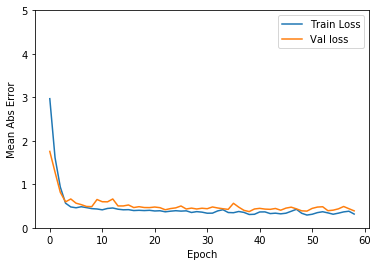

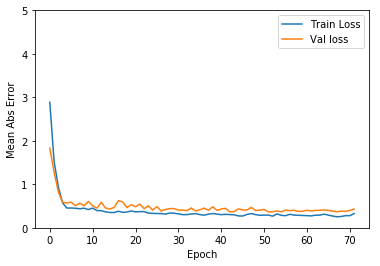

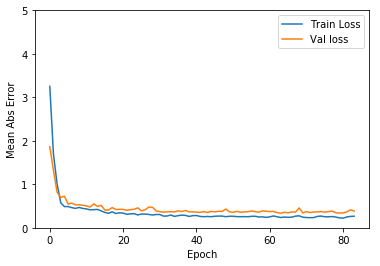

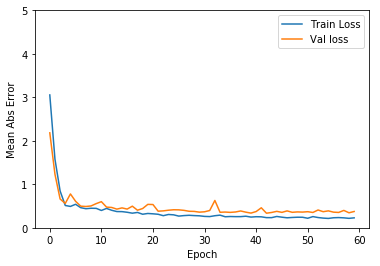

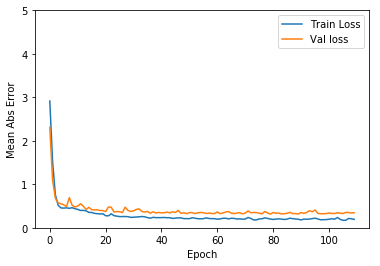

In [18]:
errors = []
for i in np.linspace(2, 4, 5):
    errors.append(cv_dropout_maxnorm(0.2, 0.5, i))

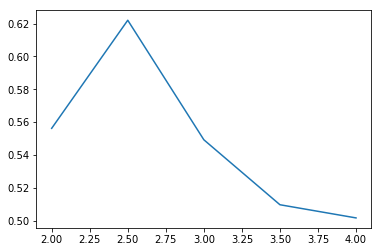

In [19]:
plt.plot(np.linspace(2, 4, 5), errors)

# Collaborative Crowd on jittered matrix

Another good way to increase performances of a neural network is to artificially add samples to the matrix we already have.

In [5]:
X_train_red = np.load(DATA_FOLDER + "x_pca_train.npy")
y_train = np.load(DATA_FOLDER + "y_pca_train.npy")
X_test_red = np.load(DATA_FOLDER + "x_pca_test.npy")
y_test = np.load(DATA_FOLDER + "y_pca_test.npy")
X_train_red.shape, y_train.shape, X_test_red.shape, y_test.shape

((22761, 3004), (22761,), (7513, 3004), (7513,))

In [6]:
cc_jitt = cc.CollaborativeCrowd(X_train_red, y_train, "CollabCrowd_jitter", nb_layers = 8, \
                      nb_neurons=156, regularization_factor=1e-6, validation_split = 0)
cc_jitt.restore()

No directory with name session/CollabCrowd_jitter_8_156_relu_1e-06_0.001_mse


In [7]:
cc_jitt.train_new_entities(1)

Epoch 1/200
22624/22761 [============================>.] - ETA: 0s - loss: 23.9304 - mean_absolute_error: 3.1023
Epoch 00001: saving model to session/CollabCrowd_jitter_8_156_relu_1e-06_0.001_mse/0
22761/22761 [==============================] - 7s 295us/step - loss: 23.8162 - mean_absolute_error: 3.0920
Epoch 2/200
22720/22761 [============================>.] - ETA: 0s - loss: 1.5192 - mean_absolute_error: 0.8994
Epoch 00002: saving model to session/CollabCrowd_jitter_8_156_relu_1e-06_0.001_mse/0
22761/22761 [==============================] - 6s 265us/step - loss: 1.5184 - mean_absolute_error: 0.8991
Epoch 3/200
22560/22761 [============================>.] - ETA: 0s - loss: 0.7851 - mean_absolute_error: 0.6541
Epoch 00003: saving model to session/CollabCrowd_jitter_8_156_relu_1e-06_0.001_mse/0
22761/22761 [==============================] - 6s 263us/step - loss: 0.7899 - mean_absolute_error: 0.6553
Epoch 4/200
22592/22761 [============================>.] - ETA: 0s - loss: 0.7636 - mean_

Epoch 28/200
22720/22761 [============================>.] - ETA: 0s - loss: 0.1802 - mean_absolute_error: 0.2897
Epoch 00028: saving model to session/CollabCrowd_jitter_8_156_relu_1e-06_0.001_mse/0
22761/22761 [==============================] - 6s 242us/step - loss: 0.1801 - mean_absolute_error: 0.2896
Epoch 29/200
22592/22761 [============================>.] - ETA: 0s - loss: 0.1564 - mean_absolute_error: 0.2653
Epoch 00029: saving model to session/CollabCrowd_jitter_8_156_relu_1e-06_0.001_mse/0
22761/22761 [==============================] - 6s 243us/step - loss: 0.1566 - mean_absolute_error: 0.2655
Epoch 30/200
22560/22761 [============================>.] - ETA: 0s - loss: 0.1264 - mean_absolute_error: 0.2417
Epoch 00030: saving model to session/CollabCrowd_jitter_8_156_relu_1e-06_0.001_mse/0
22761/22761 [==============================] - 6s 242us/step - loss: 0.1279 - mean_absolute_error: 0.2422
Epoch 31/200
22656/22761 [============================>.] - ETA: 0s - loss: 0.1548 - mea

Epoch 55/200
22592/22761 [============================>.] - ETA: 0s - loss: 0.0860 - mean_absolute_error: 0.1930
Epoch 00055: saving model to session/CollabCrowd_jitter_8_156_relu_1e-06_0.001_mse/0
22761/22761 [==============================] - 6s 242us/step - loss: 0.0858 - mean_absolute_error: 0.1927
Epoch 56/200
22560/22761 [============================>.] - ETA: 0s - loss: 0.0641 - mean_absolute_error: 0.1671
Epoch 00056: saving model to session/CollabCrowd_jitter_8_156_relu_1e-06_0.001_mse/0
22761/22761 [==============================] - 5s 240us/step - loss: 0.0643 - mean_absolute_error: 0.1674
Epoch 57/200
22752/22761 [============================>.] - ETA: 0s - loss: 0.0772 - mean_absolute_error: 0.1777
Epoch 00057: saving model to session/CollabCrowd_jitter_8_156_relu_1e-06_0.001_mse/0
22761/22761 [==============================] - 6s 243us/step - loss: 0.0771 - mean_absolute_error: 0.1777
Epoch 58/200
22592/22761 [============================>.] - ETA: 0s - loss: 0.0660 - mea

Epoch 82/200
22752/22761 [============================>.] - ETA: 0s - loss: 0.0550 - mean_absolute_error: 0.1468
Epoch 00082: saving model to session/CollabCrowd_jitter_8_156_relu_1e-06_0.001_mse/0
22761/22761 [==============================] - 6s 243us/step - loss: 0.0550 - mean_absolute_error: 0.1468
Epoch 83/200
22752/22761 [============================>.] - ETA: 0s - loss: 0.0673 - mean_absolute_error: 0.1667
Epoch 00083: saving model to session/CollabCrowd_jitter_8_156_relu_1e-06_0.001_mse/0
22761/22761 [==============================] - 6s 243us/step - loss: 0.0673 - mean_absolute_error: 0.1666
Epoch 84/200
22560/22761 [============================>.] - ETA: 0s - loss: 0.0539 - mean_absolute_error: 0.1440
Epoch 00084: saving model to session/CollabCrowd_jitter_8_156_relu_1e-06_0.001_mse/0
22761/22761 [==============================] - 6s 243us/step - loss: 0.0538 - mean_absolute_error: 0.1439
Epoch 85/200
22592/22761 [============================>.] - ETA: 0s - loss: 0.0575 - mea

Epoch 109/200
22592/22761 [============================>.] - ETA: 0s - loss: 0.0512 - mean_absolute_error: 0.1355
Epoch 00109: saving model to session/CollabCrowd_jitter_8_156_relu_1e-06_0.001_mse/0
22761/22761 [==============================] - 6s 243us/step - loss: 0.0513 - mean_absolute_error: 0.1354
Epoch 110/200
22592/22761 [============================>.] - ETA: 0s - loss: 0.0465 - mean_absolute_error: 0.1220
Epoch 00110: saving model to session/CollabCrowd_jitter_8_156_relu_1e-06_0.001_mse/0
22761/22761 [==============================] - 6s 243us/step - loss: 0.0465 - mean_absolute_error: 0.1222
Epoch 111/200
22592/22761 [============================>.] - ETA: 0s - loss: 0.0435 - mean_absolute_error: 0.1182
Epoch 00111: saving model to session/CollabCrowd_jitter_8_156_relu_1e-06_0.001_mse/0
22761/22761 [==============================] - 6s 243us/step - loss: 0.0435 - mean_absolute_error: 0.1182
Epoch 112/200
22624/22761 [============================>.] - ETA: 0s - loss: 0.0492 -

Epoch 136/200
22592/22761 [============================>.] - ETA: 0s - loss: 0.0526 - mean_absolute_error: 0.1236
Epoch 00136: saving model to session/CollabCrowd_jitter_8_156_relu_1e-06_0.001_mse/0
22761/22761 [==============================] - 6s 243us/step - loss: 0.0525 - mean_absolute_error: 0.1235
Epoch 137/200
22592/22761 [============================>.] - ETA: 0s - loss: 0.0549 - mean_absolute_error: 0.1276
Epoch 00137: saving model to session/CollabCrowd_jitter_8_156_relu_1e-06_0.001_mse/0
22761/22761 [==============================] - 6s 242us/step - loss: 0.0548 - mean_absolute_error: 0.1275
Epoch 138/200
22752/22761 [============================>.] - ETA: 0s - loss: 0.0397 - mean_absolute_error: 0.1050
Epoch 00138: saving model to session/CollabCrowd_jitter_8_156_relu_1e-06_0.001_mse/0
22761/22761 [==============================] - 6s 243us/step - loss: 0.0397 - mean_absolute_error: 0.1050
Epoch 139/200
22624/22761 [============================>.] - ETA: 0s - loss: 0.0427 -

Epoch 163/200
22720/22761 [============================>.] - ETA: 0s - loss: 0.0403 - mean_absolute_error: 0.1114
Epoch 00163: saving model to session/CollabCrowd_jitter_8_156_relu_1e-06_0.001_mse/0
22761/22761 [==============================] - 6s 244us/step - loss: 0.0403 - mean_absolute_error: 0.1113
Epoch 164/200
22656/22761 [============================>.] - ETA: 0s - loss: 0.0435 - mean_absolute_error: 0.1136
Epoch 00164: saving model to session/CollabCrowd_jitter_8_156_relu_1e-06_0.001_mse/0
22761/22761 [==============================] - 6s 260us/step - loss: 0.0435 - mean_absolute_error: 0.1136
Epoch 165/200
22688/22761 [============================>.] - ETA: 0s - loss: 0.0358 - mean_absolute_error: 0.0970
Epoch 00165: saving model to session/CollabCrowd_jitter_8_156_relu_1e-06_0.001_mse/0
22761/22761 [==============================] - 6s 253us/step - loss: 0.0359 - mean_absolute_error: 0.0971
Epoch 166/200
22624/22761 [============================>.] - ETA: 0s - loss: 0.0460 -

In [9]:
last, avg, last5 = cc_jitt.predict(X_test_red)
rmse(avg, y_test)

3.117733862088689